In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import pybiomart
import scvi
import torch
import random
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def SampleQC(adata,
             min_genes=200,
             filter_by_percent_cells=True, percent_cells_threshold=0.1,
             filter_by_percent_mt=True, percent_mt_threshold=10):
    
    n_cells = str(adata.shape[0])
    n_genes = str(adata.shape[1])
    print('Before QC: ' + n_cells + ' cells, ' + n_genes + ' genes')
    
    sc.pp.filter_cells(adata, min_genes=min_genes)
    if filter_by_percent_cells:
        sc.pp.filter_genes(adata, min_cells=round(percent_cells_threshold*adata.shape[0]/100,0))
        
    adata.layers['counts'] = scipy.sparse.csr_matrix(adata.X.copy())
    #adata.layers['log2_counts'] = scipy.sparse.csr_matrix(sc.pp.log1p(adata.layers['counts'],copy(), base=2))
    
    if filter_by_percent_mt:
        adata.var['mt'] = adata.var_names.str.startswith('MT-')
        sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
        adata.obs.rename(columns={'pct_counts_mt':'percent_mt'}, inplace=True)
        adata.var.drop('mt', axis=1, inplace=True)
        adata = adata[adata.obs['percent_mt']<percent_mt_threshold,].copy()
    
    n_cells = str(adata.shape[0])
    n_genes = str(adata.shape[1])
    print('After QC: ' + n_cells + ' cells, ' + n_genes + ' genes')
    
    return adata

In [3]:
cwd = os.getcwd()
cwd

'/Users/deanlee/GitHub/FigureOneLab/example_projects/human_microglia_brain_organoids'

In [4]:
meta1 = pd.read_csv(cwd+'/data/speicher/GSE207608_annotation_cluster.csv.gz', compression='gzip', delimiter=',', header=0)
meta1.rename(columns={'Unnamed: 0':'CellID', 'x':'CellType'}, inplace=True)

meta2 = pd.read_csv(cwd+'/data/speicher/GSE207608_annotation_sample.csv.gz', compression='gzip', delimiter=',', header=0)
meta2.rename(columns={'Unnamed: 0':'CellID', 'x':'SampleID'}, inplace=True)

meta = pd.merge(meta1, meta2, on='CellID', how='left')
meta['CellID'] = meta['CellID'].str.replace(r'-1_[1-3]', '', regex=True)
meta['CellID'] = meta['SampleID'] + '_' + meta['CellID']
meta

,CellID,CellType,SampleID
0,COC_AAACCCACATGAATAG,mesenchym,COC
1,COC_AAACCCACATGTCTAG,neuroectoderm,COC
2,COC_AAACCCAGTCACTTCC,mesenchym,COC
3,COC_AAACCCATCACTCTTA,neuroectoderm,COC
4,COC_AAACGAACACCTGCTT,mesenchym,COC
...,...,...,...
14946,Organoid_TTTGTTGCACCTAAAC,neuroectoderm,Organoid
14947,Organoid_TTTGTTGCATAGAATG,neuroectoderm,Organoid
14948,Organoid_TTTGTTGGTACCCACG,mesenchym,Organoid
14949,Organoid_TTTGTTGGTTGCTCCT,neuroectoderm,Organoid


In [5]:
meta.SampleID.value_counts()

SampleID
Organoid    6642
COC         5873
MGL         2436
Name: count, dtype: int64

In [6]:
meta.CellType.value_counts()

CellType
neuroectoderm    6929
mesenchym        3622
microglia        2652
cycling          1249
epithel           499
Name: count, dtype: int64

In [7]:
mgl = sc.read_10x_h5(cwd+'/data/speicher/GSE207608_RAW/GSM6303893_MGL_filtered_feature_bc_matrix.h5')
mgl.var.rename(columns={'gene_ids':'EnsemblID'}, inplace=True)
mgl.var = mgl.var[['EnsemblID']]
mgl.var_names_make_unique()
mgl.obs['CellID'] = mgl.obs.index
mgl.obs['CellID'] = mgl.obs['CellID'].str.replace(r'-1', '', regex=True)
mgl.obs['CellID'] = 'MGL_' + mgl.obs['CellID']
mgl = mgl[mgl.obs['CellID'].isin(meta['CellID']),:].copy()
mgl.obs = pd.merge(mgl.obs, meta, on='CellID', how='left')
mgl

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2436 × 33538
    obs: 'CellID', 'CellType', 'SampleID'
    var: 'EnsemblID'

In [8]:
coc = sc.read_10x_h5(cwd+'/data/speicher/GSE207608_RAW/GSM6303895_COC_filtered_feature_bc_matrix.h5')
coc.var.rename(columns={'gene_ids':'EnsemblID'}, inplace=True)
coc.var = coc.var[['EnsemblID']]
coc.var_names_make_unique()
coc.obs['CellID'] = coc.obs.index
coc.obs['CellID'] = coc.obs['CellID'].str.replace(r'-1', '', regex=True)
coc.obs['CellID'] = 'COC_' + coc.obs['CellID']
coc = coc[coc.obs['CellID'].isin(meta['CellID']),:].copy()
coc.obs = pd.merge(coc.obs, meta, on='CellID', how='left')
coc.obs

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,CellID,CellType,SampleID
0,COC_AAACCCACATGAATAG,mesenchym,COC
1,COC_AAACCCACATGTCTAG,neuroectoderm,COC
2,COC_AAACCCAGTCACTTCC,mesenchym,COC
3,COC_AAACCCATCACTCTTA,neuroectoderm,COC
4,COC_AAACGAACACCTGCTT,mesenchym,COC
...,...,...,...
5868,COC_TTTGTTGAGGTACTGG,mesenchym,COC
5869,COC_TTTGTTGAGTAGGTTA,mesenchym,COC
5870,COC_TTTGTTGGTACCAGAG,mesenchym,COC
5871,COC_TTTGTTGGTGACAGGT,mesenchym,COC


In [9]:
#org = sc.read_10x_h5(cwd+'/data/speicher/GSE207608_RAW/GSM6303894_Organoid_filtered_feature_bc_matrix.h5')
#org.var.rename(columns={'gene_ids':'EnsemblID'}, inplace=True)
#org.var = org.var[['EnsemblID']]
#org

In [10]:
adata = anndata.concat([mgl, coc], join='outer')
adata.obs_names_make_unique()
adata

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 8309 × 33539
    obs: 'CellID', 'CellType', 'SampleID'

In [11]:
adata = SampleQC(adata,
                 min_genes=200,
                 filter_by_percent_cells=True, percent_cells_threshold=0.1,
                 filter_by_percent_mt=True, percent_mt_threshold=10)
adata

Before QC: 8309 cells, 33539 genes
After QC: 7988 cells, 20575 genes


AnnData object with n_obs × n_vars = 7988 × 20575
    obs: 'CellID', 'CellType', 'SampleID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'percent_mt'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

In [12]:
adata_microglia = adata[adata.obs['CellType']=='microglia',:].copy()
del adata
adata_microglia

AnnData object with n_obs × n_vars = 2483 × 20575
    obs: 'CellID', 'CellType', 'SampleID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'percent_mt'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

In [13]:
%%time
random.seed(17)
scvi.model.SCVI.setup_anndata(adata_microglia, layer='counts', batch_key='SampleID')
scvi_model = scvi.model.SCVI(adata_microglia, n_layers=2, n_latent=30, n_hidden=128, gene_likelihood='nb')
scvi_model.train()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/400:   0%|                                      | 0/400 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 400/400: 100%|█| 400/400 [1:29:12<00:00, 307.94s/it, v_num=1, train_loss_s

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [1:29:12<00:00, 13.38s/it, v_num=1, train_loss_st
CPU times: user 54min 41s, sys: 7min 29s, total: 1h 2min 11s
Wall time: 1h 29min 13s


In [14]:
%%time
random.seed(17)
adata_microglia.obsm['X_scvi'] = scvi_model.get_latent_representation()
adata_microglia.layers['counts_scvi'] = scvi_model.get_normalized_expression(library_size=10000)
#adata_microglia.layers['log2_counts_scvi'] = sc.pp.log1p(adata.layers['counts_scvi'].copy(), base=2)

CPU times: user 1.08 s, sys: 366 ms, total: 1.45 s
Wall time: 570 ms


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


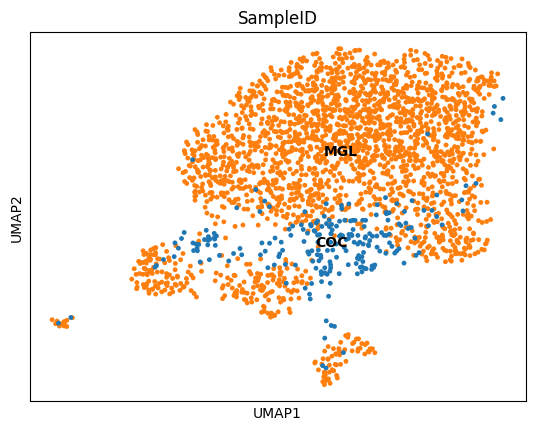

CPU times: user 8.62 s, sys: 2.57 s, total: 11.2 s
Wall time: 13min 20s


In [15]:
%%time
random.seed(17)
sc.pp.neighbors(adata_microglia, use_rep='X_scvi', key_added='neighbors_scvi', n_neighbors=20)
sc.tl.leiden(adata_microglia, neighbors_key='neighbors_scvi', key_added='leiden_scvi', resolution=3)
sc.tl.umap(adata_microglia, neighbors_key='neighbors_scvi')
sc.pl.umap(adata_microglia, color=['SampleID'], legend_loc='on data')

In [16]:
adata_microglia.write(cwd+'/outs/240201_speicher_microglia_scvi.h5ad')
scvi_model.save(cwd+'/outs/240201_speicher_microglia_scvi_model/', overwrite=True)